# World Modelling

In [35]:
# Imports and setup
import cv2
import numpy as np
import torch
from matplotlib import pyplot as plt
from matplotlib import patches as patches
from ultralytics import YOLO
import requests
import os
from dotenv import load_dotenv
from depth_anything_v2.dpt import DepthAnythingV2

# Load environment variables
load_dotenv()
api_key = os.getenv("API_KEY")

## Object Detection with YOLO

In [36]:
yolo_model = YOLO('yolov8n.pt')

In [37]:
def detect_objects(img_path, yolo_model):
    frame = cv2.imread(img_path)
    if frame is None:
        raise ValueError(f"Could not load image: {img_path}")
    results = yolo_model(frame)
    objects = []
    for result in results:
        for box in result.boxes:
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            label = yolo_model.model.names[int(box.cls)]
            conf = float(box.conf)
            if conf < 0.3:
                continue
            cx = (x1 + x2) // 2
            cy = (y1 + y2) // 2
            objects.append({
                'label': label,
                'confidence': conf,
                'bbox': (x1, y1, x2, y2),
                'center_2d': (cx, cy)
            })
            cv2.rectangle(frame, (x1, y1), (x2, y2), (0,255,0), 2)
            cv2.putText(
                frame, f"{label} {conf:.2f}", (x1, y1-10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 2
            )
    return frame, objects

def show_img(img_path):
    plt.imshow(cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB))
    plt.title(img_path)
    plt.axis('off')
    plt.show()

def show_img_objects(frame, objects):
    plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    plt.title("YOLO Detection")
    plt.axis('off')
    plt.show()

## Depth Estimation with Depth Anything V2

In [38]:
depth_model_configs = {'vits': {'encoder': 'vits', 'features': 64, 'out_channels': [48, 96, 192, 384]}}
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
depth_model = DepthAnythingV2(**depth_model_configs['vits'])
depth_model.load_state_dict(torch.load('depth_anything_v2_vits.pth', map_location=DEVICE))
depth_model = depth_model.to(DEVICE).eval()

In [39]:
def estimate_depth(frame, depth_model):
    img_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    with torch.no_grad():
        depth = depth_model.infer_image(img_rgb)
    depth = depth.squeeze()
    max_depth = depth.max()
    depth = max_depth - depth
    depth_vis = (depth - depth.min()) / (depth.max() - depth.min())

    return depth, depth_vis

def add_object_depths(objects, depth_map):
    for obj in objects:
        x1, y1, x2, y2 = obj['bbox']
        x1c, y1c = max(0, x1), max(0, y1)
        x2c, y2c = min(depth_map.shape[1], x2), min(depth_map.shape[0], y2)
        box_depth = depth_map[y1c:y2c, x1c:x2c]
        valid_depths = box_depth[box_depth > 0]
        if valid_depths.size > 0:
            avg_depth = float(np.median(valid_depths))
        else:
            avg_depth = float('nan')
        obj['avg_depth'] = avg_depth
    return objects

def format_object_info_with_depths(objects):
    if not objects:
        return "No objects detected."
    lines = []
    for obj in objects:
        depth_str = f"{obj['avg_depth']:.2f}m" if np.isfinite(obj['avg_depth']) else "unknown"
        lines.append(
            f"Object: {obj['label']}, Confidence: {obj['confidence']:.2f}, Estimated Distance: {depth_str}"
        )
    return "\n".join(lines)

def show_depth_objects(depth_vis, objects):
    plt.figure()
    plt.imshow(depth_vis, cmap='viridis')
    ax = plt.gca()
    for obj in objects:
        x1, y1, x2, y2 = obj['bbox']
        rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, edgecolor='lime', facecolor='none')
        ax.add_patch(rect)
        label = obj['label']
        depth_str = f"{obj['avg_depth']:.2f}m" if np.isfinite(obj['avg_depth']) else "unknown"
        ax.text(x1, y1-5, f"{label} ({depth_str})", color='white', fontsize=10, bbox=dict(facecolor='black', alpha=0.5, pad=1))
    plt.title("Estimated Depth with Detected Objects")
    plt.axis('off')
    plt.show()

## Point Clouds

In [40]:
camera_intrinsics = {
    'fx': 552.554,  # focal length x
    'fy': 552.554,  # focal length y
    'cx': 320.5,    # principal point x
    'cy': 240.5     # principal point y
}

In [41]:
def generate_object_point_clouds(objects, depth_map, camera_intrinsics):
    fx, fy, cx, cy = camera_intrinsics['fx'], camera_intrinsics['fy'], camera_intrinsics['cx'], camera_intrinsics['cy']
    object_point_clouds = []
    for obj in objects:
        x1, y1, x2, y2 = obj['bbox']
        x1c, y1c = max(0, x1), max(0, y1)
        x2c, y2c = min(depth_map.shape[1], x2), min(depth_map.shape[0], y2)
        # Get pixel grid for the bounding box
        xs = np.arange(x1c, x2c)
        ys = np.arange(y1c, y2c)
        if xs.size == 0 or ys.size == 0:
            continue
        xv, yv = np.meshgrid(xs, ys)
        zv = depth_map[yv, xv]
        mask = zv > 0
        if not np.any(mask):
            continue
        # Camera projection: X = (u-cx)*Z/fx, Y = (v-cy)*Z/fy, Z = depth
        u = xv[mask]
        v = yv[mask]
        z = zv[mask]
        x = (u - cx) * z / fx
        y = (v - cy) * z / fy
        points = np.stack([x, y, z], axis=1)
        object_point_clouds.append({
            'label': obj['label'],
            'bbox': obj['bbox'],
            'points': points
        })
    return object_point_clouds

def format_object_info_with_point_clouds(object_point_clouds):
    """
    For each object, compute the 3D bounding box corners:
    - top left front, top left back, bottom left front, bottom left back,
      top right front, top right back, bottom right front, bottom right back.
    Returns a string with the label, confidence, and 3D bbox corners in metres.
    """
    if not object_point_clouds:
        return "No object point clouds generated."
    lines = []
    for obj_pc in object_point_clouds:
        label = obj_pc['label']
        pts = obj_pc['points']
        # Find min/max for each axis
        min_x, min_y, min_z = np.min(pts, axis=0)
        max_x, max_y, max_z = np.max(pts, axis=0)
        # 8 corners of the 3D bounding box
        corners = {
            "top_left_front":    (min_x, max_y, min_z),
            "top_left_back":     (min_x, max_y, max_z),
            "bottom_left_front": (min_x, min_y, min_z),
            "bottom_left_back":  (min_x, min_y, max_z),
            "top_right_front":   (max_x, max_y, min_z),
            "top_right_back":    (max_x, max_y, max_z),
            "bottom_right_front":(max_x, min_y, min_z),
            "bottom_right_back": (max_x, min_y, max_z),
        }
        corners_str = ", ".join(
            [f"{name}: [{x:.2f},{y:.2f},{z:.2f}]" for name, (x, y, z) in corners.items()]
        )
        lines.append(f"Object: {label}, 3D bbox corners (metres): {corners_str}")
    return "\n".join(lines)

def show_point_clouds(object_point_clouds):
    import matplotlib.pyplot as plt
    from mpl_toolkits.mplot3d import Axes3D

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k']
    for idx, obj_pc in enumerate(object_point_clouds):
        points = obj_pc['points']
        if points.shape[0] == 0:
            continue
        color = colors[idx % len(colors)]
        ax.scatter(points[:, 2], points[:, 0], -points[:, 1], s=1, c=color, label=obj_pc['label'])
    ax.set_xlabel('Z (m)')
    ax.set_ylabel('X (m)')
    ax.set_zlabel('Y (m)')
    ax.set_xlim([max(points[:, 2]), 0])
    ax.set_title('Object Point Clouds')
    ax.legend()
    plt.show()

## LLM Query with DeepSeek

In [ ]:
def query_llm_depth_objects(objects):
    object_info = format_object_info_with_depths(objects)
    llm_prompt = (
        "You are Nao, a robot dance instructor for children."
        "You have already introduced yourself to the child and are about to begin teaching a class, but first you need to check if the room is safe."
        "Here is a list of objects detected in the room, with their estimated distances from the camera:\n"
        "{0}\n"
        "First, provide a detailed explanation of your reasoning about the safety of the room. Then, give the actual response you would say to the child in only one or two sentences."
        "Don't mention numbers or technical details in your response to the child."
        "Remember you are communicating with a child through text-to-speech so be clear and concise."
    ).format(object_info)

    headers = {
        "Authorization": f"Bearer {api_key}",
        "Content-Type": "application/json",
        "HTTP-Referer": "http://localhost",
        "X-Title": "HRI Project - Nao as Dance Instructor",
    }

    data_model = {
        "model": "deepseek/deepseek-chat-v3-0324:free",
        "messages": [
            {"role": "system", "content": "You are Nao, a robot dance instructor. You help ensure the environment is safe for dancing."},
            {"role": "user", "content": llm_prompt}
        ]
    }

    response = requests.post(
        "https://openrouter.ai/api/v1/chat/completions",
        headers=headers,
        json=data_model
    )

    return response.json()["choices"][0]["message"]["content"]

def query_llm_pointcloud_objects(object_point_clouds):
    object_info = format_object_info_with_point_clouds(object_point_clouds)
    llm_prompt = (
        "You are Nao, a robot dance instructor for children."
        "You have already introduced yourself to the child and are about to begin teaching a class, but first you need to check if the room is safe."
        "Here is a list of objects detected in the room, with their 3D bounding boxes in metres:\n"
        f"{object_info}\n"
        "First, provide a detailed explanation of your reasoning about the safety of the room. Then, give the actual response you would say to the child in only one or two sentences."
        "Don't mention numbers or technical details in your response to the child."
        "Remember you are communicating with a child through text-to-speech so be clear and concise."
    )

    headers = {
        "Authorization": f"Bearer {api_key}",
        "Content-Type": "application/json",
        "HTTP-Referer": "http://localhost",
        "X-Title": "HRI Project - Nao as Dance Instructor",
    }

    data_model = {
        "model": "deepseek/deepseek-chat-v3-0324:free",
        "messages": [
            {"role": "system", "content": "You are Nao, a robot dance instructor. You help ensure the environment is safe for dancing."},
            {"role": "user", "content": llm_prompt}
        ]
    }

    response = requests.post(
        "https://openrouter.ai/api/v1/chat/completions",
        headers=headers,
        json=data_model
    )

    return response.json()["choices"][0]["message"]["content"]

In [43]:
# Query LLM with only the depth map (sample 20x20 grid from the map)
def query_llm_depth_only(depth_map):
    # Sample 20 evenly spaced points along each axis
    h, w = depth_map.shape
    y_idx = np.linspace(0, h - 1, 20, dtype=int)
    x_idx = np.linspace(0, w - 1, 20, dtype=int)
    sampled = depth_map[np.ix_(y_idx, x_idx)]
    sampled_list = np.round(sampled, 2).tolist()
    llm_prompt = (
        "You are Nao, a robot dance instructor for children."
        "You have already introduced yourself to the child and are about to begin teaching a class, but first you need to check if the room is safe."
        "Here is a sampled grid of the estimated depth map of the room (each value is the estimated distance in meters from the camera, sampled at 20x20 points):\n"
        f"{sampled_list}\n"
        "First, provide a detailed explanation of your reasoning about the safety of the room. Then, give the actual response you would say to the child in only one or two sentences."
        "Don't mention numbers or technical details in your response to the child."
        "Remember you are communicating with a child through text-to-speech so be clear and concise."
    )
    headers = {
        "Authorization": f"Bearer {api_key}",
        "Content-Type": "application/json",
        "HTTP-Referer": "http://localhost",
        "X-Title": "HRI Project - Nao as Dance Instructor",
    }
    data_model = {
        "model": "deepseek/deepseek-chat-v3-0324:free",
        "messages": [
            {"role": "system", "content": "You are Nao, a robot dance instructor. You help ensure the environment is safe for dancing."},
            {"role": "user", "content": llm_prompt}
        ]
    }
    response = requests.post(
        "https://openrouter.ai/api/v1/chat/completions",
        headers=headers,
        json=data_model
    )
    return response.json()["choices"][0]["message"]["content"]

In [44]:
# Query LLM with only the detected objects
def query_llm_objects_only(objects):
    if not objects:
        object_info = "No objects detected."
    else:
        lines = []
        for obj in objects:
            # Only include label and confidence, not depth
            lines.append(f"Object: {obj['label']}, Confidence: {obj['confidence']:.2f}")
        object_info = "\n".join(lines)
    llm_prompt = (
        "You are Nao, a robot dance instructor for children."
        "You have already introduced yourself to the child and are about to begin teaching a class, but first you need to check if the room is safe."
        "Here is a list of objects detected in the room:\n"
        f"{object_info}\n"
        "Remember: you need a safe space of approximately 5 metres for dancing."
        "First, provide a detailed explanation of your reasoning about the safety of the room. Then, give the actual response you would say to the child in only one or two sentences."
        "Don't mention numbers or technical details in your response to the child."
        "Remember you are communicating with a child through text-to-speech so be clear and concise."
    )
    headers = {
        "Authorization": f"Bearer {api_key}",
        "Content-Type": "application/json",
        "HTTP-Referer": "http://localhost",
        "X-Title": "HRI Project - Nao as Dance Instructor",
    }
    data_model = {
        "model": "deepseek/deepseek-chat-v3-0324:free",
        "messages": [
            {"role": "system", "content": "You are Nao, a robot dance instructor. You help ensure the environment is safe for dancing."},
            {"role": "user", "content": llm_prompt}
        ]
    }
    response = requests.post(
        "https://openrouter.ai/api/v1/chat/completions",
        headers=headers,
        json=data_model
    )
    return response.json()["choices"][0]["message"]["content"]

## Example 1: Safe Environment

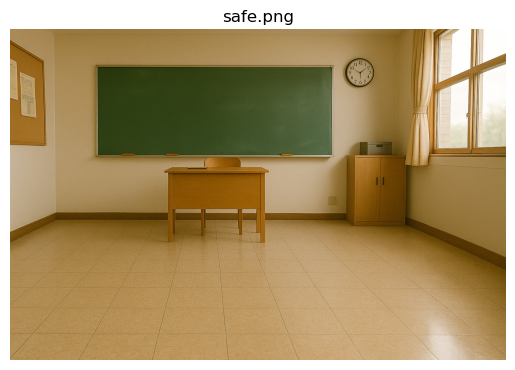


0: 448x640 1 chair, 1 tv, 1 refrigerator, 1 clock, 65.8ms
Speed: 4.3ms preprocess, 65.8ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)


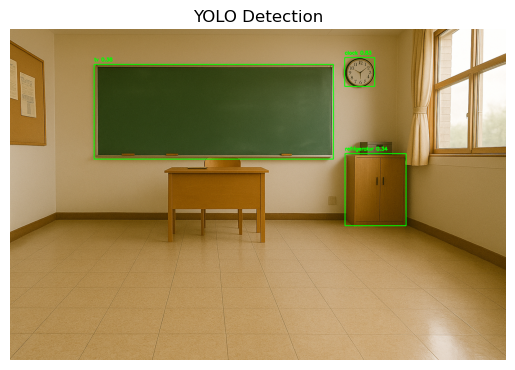

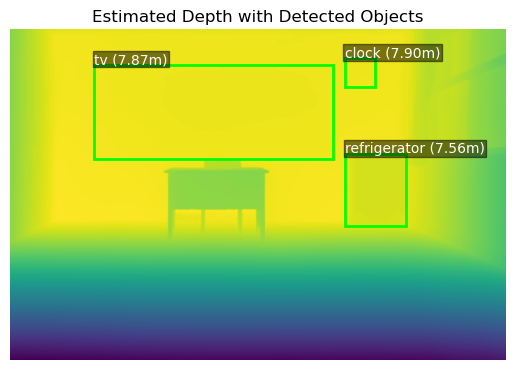

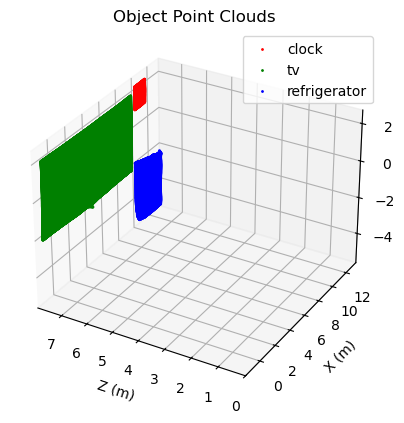

In [65]:
img_path = "safe.png"
show_img(img_path)

frame, objects = detect_objects(img_path, yolo_model)
show_img_objects(frame, objects)

depth_map, depth_vis = estimate_depth(frame, depth_model)
objects = add_object_depths(objects, depth_map)
show_depth_objects(depth_vis, objects)

object_point_clouds = generate_object_point_clouds(objects, depth_map, camera_intrinsics)
show_point_clouds(object_point_clouds)

In [67]:
h, w = depth_map.shape
y_idx = np.linspace(0, h - 1, 20, dtype=int)
x_idx = np.linspace(0, w - 1, 20, dtype=int)
sampled = depth_map[np.ix_(y_idx, x_idx)]
sampled_list = np.round(sampled, 2).tolist()

In [68]:
if not objects:
    object_info = "No objects detected."
else:
    lines = []
    for obj in objects:
        # Only include label and confidence, not depth
        lines.append(f"Object: {obj['label']}, Confidence: {obj['confidence']:.2f}")
    object_info = "\n".join(lines)
object_info

'Object: clock, Confidence: 0.83\nObject: tv, Confidence: 0.38\nObject: refrigerator, Confidence: 0.34'

In [69]:
format_object_info_with_depths(objects)

'Object: clock, Confidence: 0.83, Estimated Distance: 7.90m\nObject: tv, Confidence: 0.38, Estimated Distance: 7.87m\nObject: refrigerator, Confidence: 0.34, Estimated Distance: 7.56m'

In [70]:
format_object_info_with_point_clouds(object_point_clouds)

'Object: clock, 3D bbox corners (metres): top_left_front: [10.22,-0.92,7.89], top_left_back: [10.22,-0.92,7.92], bottom_left_front: [10.22,-2.18,7.89], bottom_left_back: [10.22,-2.18,7.92], top_right_front: [11.57,-0.92,7.89], top_right_back: [11.57,-0.92,7.92], bottom_right_front: [11.57,-2.18,7.89], bottom_right_back: [11.57,-2.18,7.92]\nObject: tv, 3D bbox corners (metres): top_left_front: [-0.87,2.32,7.67], top_left_back: [-0.87,2.32,7.98], bottom_left_front: [-0.87,-1.88,7.67], bottom_left_back: [-0.87,-1.88,7.98], top_right_front: [9.77,2.32,7.67], top_right_back: [9.77,2.32,7.98], bottom_right_front: [9.77,-1.88,7.67], bottom_right_back: [9.77,-1.88,7.98]\nObject: refrigerator, 3D bbox corners (metres): top_left_front: [10.02,5.12,7.50], top_left_back: [10.02,5.12,7.95], bottom_left_front: [10.02,1.97,7.50], bottom_left_back: [10.02,1.97,7.95], top_right_front: [12.50,5.12,7.50], top_right_back: [12.50,5.12,7.95], bottom_right_front: [12.50,1.97,7.50], bottom_right_back: [12.50,

In [46]:
try:
    llm_response = query_llm_depth_objects(objects)
    print("\nLLM Response (Depth and Objects):")
    print(llm_response)
except:
    llm_response = "Error querying LLM with depth and objects."
    print(llm_response)


LLM Response (Depth and Objects):
**Reasoning:**  
The objects detected (clock, TV, refrigerator) are all more than 7 meters away, which is far enough from the dance area to pose no immediate safety risk. The low confidence scores for the TV and refrigerator suggest they may not be accurately identified or relevant to the immediate space. No nearby hazards (e.g., sharp edges, small objects, or tripping risks) are detected, so the room appears safe for dancing.  

**Response to the child:**  
"Great news! The room looks safe and ready for dancing. Let’s get started—are you excited?"


In [47]:
try:
    llm_response = query_llm_pointcloud_objects(object_point_clouds)
    print("\nLLM Response (Point Cloud and Objects):")
    print(llm_response)
except:
    llm_response = "Error querying LLM with point clouds and objects."
    print(llm_response)


LLM Response (Point Cloud and Objects):
**Safety Reasoning:**  
1. **Clock** – Mounted high on a wall (~7.89m height), far from the dance area. No risk of collision.  
2. **TV** – Spans a wide area but is flush against a wall (~7.67m height). Too high to interfere with movement.  
3. **Refrigerator** – Positioned against a wall in a distant corner (~10m away). No obstructions to the dance space.  
**Conclusion:** The room is safe—all objects are either anchored or out of reach.  

**Response to the Child:**  
*"Great news! The room is all clear and safe for dancing. Let’s get started!"*


In [48]:
try:
    llm_response_depth = query_llm_depth_only(depth_map)
    print("\nLLM Response (Depth Only):")
    print(llm_response_depth)
except:
    print("Error querying LLM with depth map only.")


LLM Response (Depth Only):
**Safety Assessment Reasoning:**  
The depth map shows a mostly open space with consistent distances (6-8 meters) in the central and far areas, suggesting a clear dance floor. However, there are closer objects (0.15–2.4 meters) near the edges/corners—likely walls or furniture—and a few abrupt drops in depth (e.g., 0.01–1.47 meters) that could indicate tripping hazards like steps or low objects. The room is *mostly* safe but requires avoiding the closer edges.  

**Response to the Child:**  
"Great news! Our dance space is ready—just stay in the middle where it’s nice and open, and we’ll have tons of fun!"


In [49]:
try:
    llm_response_objects = query_llm_objects_only(objects)
    print("\nLLM Response (Objects Only):")
    print(llm_response_objects)
except:
    print("Error querying LLM with objects only.")


LLM Response (Objects Only):
**Reasoning:**  
The room appears mostly safe for dancing—the clock is likely mounted on a wall, posing little risk. The TV and refrigerator have low detection confidence (0.38 and 0.34, respectively), suggesting they might not actually be present or are misidentified. Even if they were real, they’re likely stationary and not in the dancing space. However, I’d double-check for any actual hazards (e.g., loose wires or small objects) before proceeding. Assuming the floor is clear, the 5-meter space requirement seems met.  

**Response to the child:**  
"Great news! Our dance space looks safe and ready. Let’s get moving and have some fun!"


## Example 2: Furniture

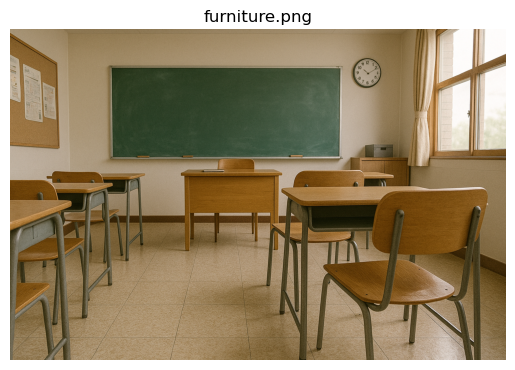


0: 448x640 4 chairs, 3 dining tables, 1 tv, 1 clock, 58.9ms
Speed: 2.2ms preprocess, 58.9ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)
0: 448x640 4 chairs, 3 dining tables, 1 tv, 1 clock, 58.9ms
Speed: 2.2ms preprocess, 58.9ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)


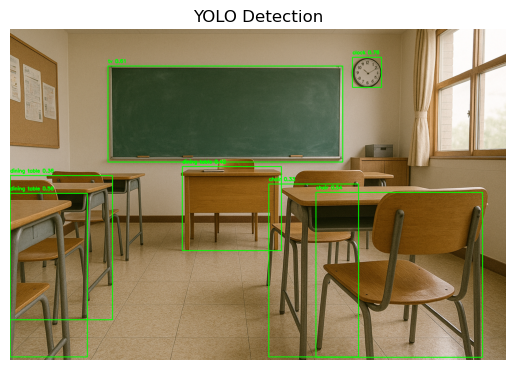

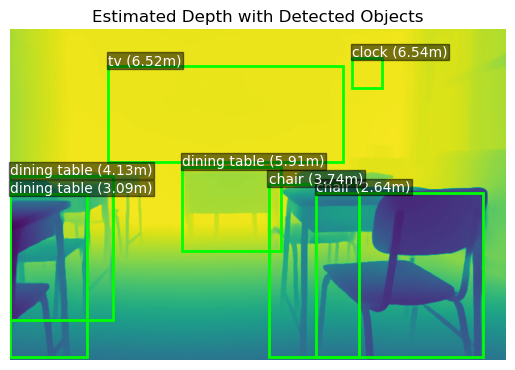

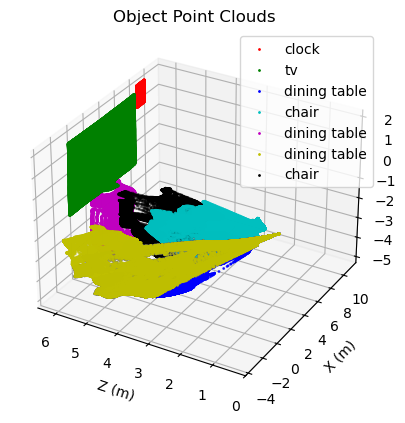

In [50]:
img_path = "furniture.png"
show_img(img_path)

frame, objects = detect_objects(img_path, yolo_model)
show_img_objects(frame, objects)

depth_map, depth_vis = estimate_depth(frame, depth_model)
objects = add_object_depths(objects, depth_map)
show_depth_objects(depth_vis, objects)

object_point_clouds = generate_object_point_clouds(objects, depth_map, camera_intrinsics)
show_point_clouds(object_point_clouds)

In [51]:
try:
    llm_response = query_llm_depth_objects(objects)
    print("\nLLM Response (Depth and Objects):")
    print(llm_response)
except:
    llm_response = "Error querying LLM with depth and objects."
    print(llm_response)


LLM Response (Depth and Objects):
**Safety Reasoning:**  
The room appears mostly safe for dancing since all detected objects (clock, TV, dining tables, and chairs) are at least 2.5 meters away—beyond a reasonable movement range for a child. However, the chairs and dining tables are the closest obstacles, so we should encourage staying centered in the open space to avoid accidental bumps. The TV and clock are far away and pose no immediate risk.  

**Response to the Child:**  
"Great news! Our dance space looks nice and clear—just stay in the open area, and we’ll have lots of fun moving safely!"


In [52]:
try:
    llm_response = query_llm_pointcloud_objects(object_point_clouds)
    print("\nLLM Response (Point Cloud and Objects):")
    print(llm_response)
except:
    llm_response = "Error querying LLM with point clouds and objects."
    print(llm_response)


LLM Response (Point Cloud and Objects):
**Safety Reasoning:**  
The room contains multiple large objects like dining tables, chairs, a TV, and a clock. The tables and chairs are positioned in a way that could obstruct movement or pose tripping hazards if children dance near them. The TV is mounted high (based on Z-values), so it's unlikely to interfere, while the clock is placed out of the way. The biggest concern is the chairs and tables cluttering the space—they should ideally be moved or arranged to create a clear, open area for dancing.  

**Response to the Child:**  
*"Hey there! Before we start dancing, let's make sure we have plenty of space to move safely. Can we push these chairs and tables to the side together?"*


In [53]:
try:
    llm_response_depth = query_llm_depth_only(depth_map)
    print("\nLLM Response (Depth Only):")
    print(llm_response_depth)
except:
    print("Error querying LLM with depth only.")


LLM Response (Depth Only):
**Safety Analysis:**  
The depth map shows most of the room is consistently deep (5-6 meters), meaning the floor is flat and unobstructed for dancing. However, there’s a concerning area near the child (values below 1 meter) indicating a potential obstacle or drop-off close by—likely unsafe for fast movements. The rest of the room is safe if they avoid that spot.  

**Response to the Child:**  
"Great news! Our dance space is almost ready—just avoid that corner over there where the floor is bumpy. Let’s dance where it’s smooth and safe!"


In [54]:
try:
    llm_response_objects = query_llm_objects_only(objects)
    print("\nLLM Response (Objects Only):")
    print(llm_response_objects)
except:
    print("Error querying LLM with objects only.")


LLM Response (Objects Only):
### Reasoning:  
The room contains several objects like a dining table and chairs that could pose obstacles during dancing. While the clock and TV are present, they are likely mounted or placed out of the way, so they aren’t major concerns. However, the repeated detections of tables and chairs suggest there may not be a clear 5-meter space for safe movement. Moving or securing these objects would be necessary before dancing.  

### Response to the child:  
"Hey dancer! Before we start, let’s move these chairs and tables to the side so we have lots of safe space to move and groove!"


## Example 3: Puddle

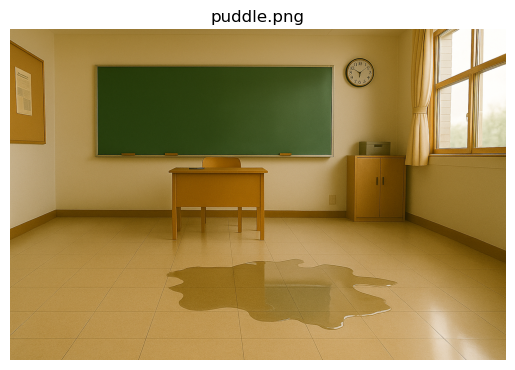


0: 448x640 1 tv, 1 refrigerator, 1 clock, 62.5ms
Speed: 2.0ms preprocess, 62.5ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)
0: 448x640 1 tv, 1 refrigerator, 1 clock, 62.5ms
Speed: 2.0ms preprocess, 62.5ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)


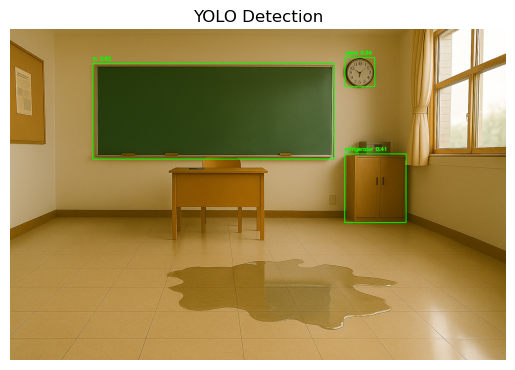

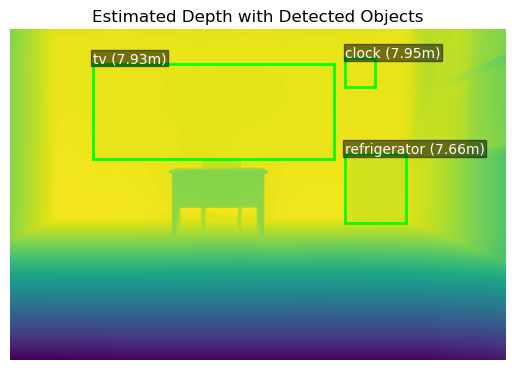

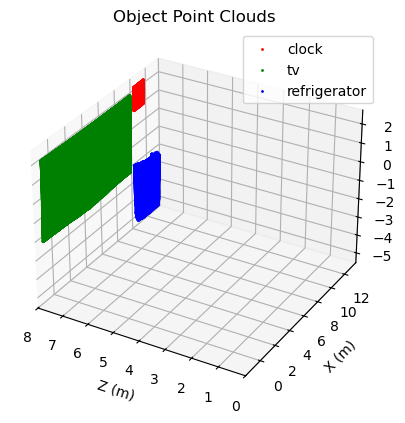

In [55]:
img_path = "puddle.png"
show_img(img_path)

frame, objects = detect_objects(img_path, yolo_model)
show_img_objects(frame, objects)

depth_map, depth_vis = estimate_depth(frame, depth_model)
objects = add_object_depths(objects, depth_map)
show_depth_objects(depth_vis, objects)

object_point_clouds = generate_object_point_clouds(objects, depth_map, camera_intrinsics)
show_point_clouds(object_point_clouds)

In [56]:
try:
    llm_response = query_llm_depth_objects(objects)
    print("\nLLM Response (Depth and Objects):")
    print(llm_response)
except:
    llm_response = "Error querying LLM with depth and objects."
    print(llm_response)


LLM Response (Depth and Objects):
**Safety Reasoning:**  
The clock, TV, and refrigerator are all far away from the dance area (over 7 meters), which means they pose no immediate hazard. However, the lower confidence score for the refrigerator (0.41) suggests the detection may be less reliable, so I'll remind the child not to wander too close to walls or furniture just in case. Otherwise, the space is clear and safe for dancing!  

**Response to the Child:**  
"Great news! Our dance space is nice and safe. Just remember to stay in the open area where we have lots of room to move!"


In [57]:
try:
    llm_response = query_llm_pointcloud_objects(object_point_clouds)
    print("\nLLM Response (Point Cloud and Objects):")
    print(llm_response)
except:
    llm_response = "Error querying LLM with point clouds and objects."
    print(llm_response)


LLM Response (Point Cloud and Objects):
**Safety Reasoning:**  
The room has three main objects:  
1. **Clock:** Mounted high on a wall (z-coordinate ~7.94–7.98m), posing no tripping or collision risk.  
2. **TV:** Spans a large area horizontally (x: -0.94–9.89m, y: -1.94–2.33m) but is wall-mounted at a safe height (z: ~7.87–8.03m), so no hazards.  
3. **Refrigerator:** Positioned against a wall (x: 10.08–12.74m, z: 7.62–8.00m), its corners are far from the likely dance area and pose no immediate danger.  

**Conclusion:** The room is safe—all objects are either out of reach or against walls, leaving ample open space for dancing.  

**Response to the Child:**  
"Everything looks safe and ready for dancing! Let’s have fun and move to the music!"


In [58]:
try:
    llm_response_depth = query_llm_depth_only(depth_map)
    print("\nLLM Response (Depth Only):")
    print(llm_response_depth)
except:
    print("Error querying LLM with depth only.")


LLM Response (Depth Only):
**Reasoning:**  
The depth map data shows consistent distances in most areas, suggesting a large, open space suitable for movement—most readings are between 6-8 meters, which is safe for dancing. However, the bottom-left corner (nearer distances around 0.15–1.4 meters) likely indicates furniture, walls, or obstacles. The room is mostly safe, but children should avoid the shorter-distance areas to prevent collisions.  

**Response to the child:**  
*"Great news! We have plenty of space to dance—just stay away from the edges of the room so we don’t bump into anything. Ready to move?"*


In [59]:
try:
    llm_response_objects = query_llm_objects_only(objects)
    print("\nLLM Response (Objects Only):")
    print(llm_response_objects)
except:
    print("Error querying LLM with objects only.")


LLM Response (Objects Only):
**Reasoning:**  
The room contains a clock and a TV, both detected with moderate confidence, but they are likely mounted or placed out of reach, posing minimal risk. The refrigerator, detected with lower confidence, suggests it might be a misidentification or not a hazard given typical dance spaces. Since none of these objects obstruct the 5-meter dancing area, the room appears safe for movement.  

**Response to the child:**  
"Great news! The room looks safe and ready for dancing. Let’s have some fun!"
